In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.transform import pyramid_gaussian

import sscPhantom 
import xraydb

# # skimage.transform.pyramid_gaussian(image, max_layer=-1, downscale=2, sigma=None, order=1, mode='reflect', cval=0, preserve_range=False, *, channel_axis=None)[source]
# image = data.camera()
# rows, cols = image.shape
# pyramid = tuple(pyramid_gaussian(image, downscale=2,max_layer=3,order=3))

# for i in range(0,len(pyramid)):
#     print(pyramid[i].shape)

/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.0.0. is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
def calculate_delta_beta_xraydb(material,energy):
    
    if material == 'Ni': # nickel
        density = 8.908 # g/cm^3
    elif material == 'Si': # silicon
        density = 2.329002
    elif material == 'W': # tungsten
        density = 19.25
    elif material == 'Au': # gold
        density = 19.3
    elif material == 'C': # carbon
        density = 2.2
        
    delta, beta, attenuation_length = xraydb.xray_delta_beta(material,density,energy)
    return delta, beta 

def get_phantom(inputs):

    params = { 'HowMany': 10,
               'radius': 0.07,
               'Rtorus': 0.5,
               'rtorus': 0.1}
    
    phantom2, phantom1 = sscPhantom.donuts.createDonuts( inputs["matrix_size"],inputs["n_cpus"], inputs["energy"], params )
    
    print(np.max(phantom1), np.mean(phantom1), np.min(phantom1))
    print(np.max(phantom2), np.mean(phantom2), np.min(phantom2))    
    
    # phantom2 = phantom2/np.max(phantom2)
    # delta, beta = calculate_delta_beta_xraydb('C',inputs["energy"]*1e3)
    # print(delta,beta)
    # phantom2 = beta*phantom2*np.exp(1j*delta*phantom2)

    # mean = np.mean(phantom1[phantom1>0])
    # print('mean',mean)
    
    # Gold
    # phantom1 = phantom1/np.max(phantom1)

    donut = phantom1 + phantom2
    phantom = np.swapaxes(donut,1,0)

    return phantom

In [3]:
inputs = {}
inputs["matrix_size"] = 256
inputs["n_cpus"] = 32 
inputs["energy"] = 9

In [4]:
phantom = get_phantom(inputs)
phantom.shape

--> ssc-phantom: particles generated / elapsed: 29.37623357772827
sscPhantom: creating 2 256x256x256 shared arrays (Phantom)
Done: 256 images within 4.979485988616943 sec
--> ssc-phantom: donuts created / elapsed: 4.979648113250732
725.3254 8.874468 0.0
5616.179 1.2794609 0.0


(256, 256, 256)

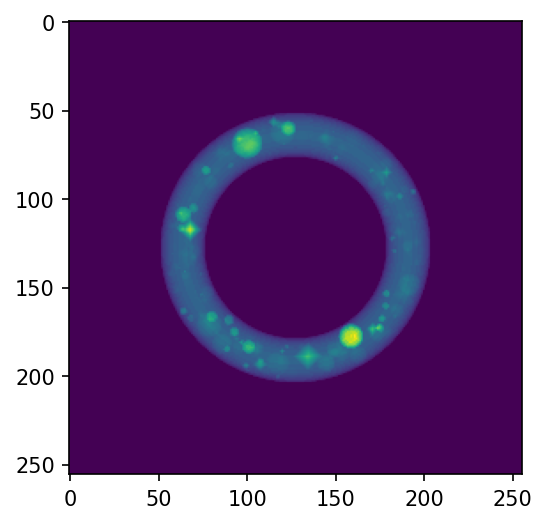

In [5]:
proj = np.sum(phantom,axis=0)

fig, ax = plt.subplots(dpi=150)
ax.imshow(np.abs(proj))

In [6]:
from scipy.ndimage import rotate

def rotate_matrix(matrix,angle,rotation_point=None):
    
    if rotation_point == None:
        rotation_point = (matrix.shape[0]//2,matrix.shape[1]//2)

    real_part, imag_part = matrix.real, matrix.imag 
    rotated_matrix = rotate(real_part,angle,axes=(0,2),reshape=False)
    
    return rotated_matrix

angles = np.linspace(0,180,360+1)
# angles = [0,1,2,3,4]
sinogram = np.empty((len(angles),phantom.shape[0],phantom.shape[1]))
for i, angle in enumerate(angles):
    phantom_rotated = rotate_matrix(phantom,angle)
    proj = np.sum(phantom_rotated,axis=0)
    sinogram[i] = proj
    print(i,angle)
    # fig, ax = plt.subplots(dpi=100)
    # ax.imshow(proj)
    # plt.show()
    # plt.close()
    
np.save('regular_angles_donut.npy',sinogram)    

0 0.0
1 0.5
2 1.0
3 1.5
4 2.0
5 2.5
6 3.0
7 3.5
8 4.0
9 4.5
10 5.0
11 5.5
12 6.0
13 6.5
14 7.0
15 7.5
16 8.0
17 8.5
18 9.0
19 9.5
20 10.0
21 10.5
22 11.0
23 11.5
24 12.0
25 12.5
26 13.0
27 13.5
28 14.0
29 14.5
30 15.0
31 15.5
32 16.0
33 16.5
34 17.0
35 17.5
36 18.0
37 18.5
38 19.0
39 19.5
40 20.0
41 20.5
42 21.0
43 21.5
44 22.0
45 22.5
46 23.0
47 23.5
48 24.0
49 24.5
50 25.0
51 25.5
52 26.0
53 26.5
54 27.0
55 27.5
56 28.0
57 28.5
58 29.0
59 29.5
60 30.0
61 30.5
62 31.0
63 31.5
64 32.0
65 32.5
66 33.0
67 33.5
68 34.0
69 34.5
70 35.0
71 35.5
72 36.0
73 36.5
74 37.0
75 37.5
76 38.0
77 38.5
78 39.0
79 39.5
80 40.0
81 40.5
82 41.0
83 41.5
84 42.0
85 42.5
86 43.0
87 43.5
88 44.0
89 44.5
90 45.0
91 45.5
92 46.0
93 46.5
94 47.0
95 47.5
96 48.0
97 48.5
98 49.0
99 49.5
100 50.0
101 50.5
102 51.0
103 51.5
104 52.0
105 52.5
106 53.0
107 53.5
108 54.0
109 54.5
110 55.0
111 55.5
112 56.0
113 56.5
114 57.0
115 57.5
116 58.0
117 58.5
118 59.0
119 59.5
120 60.0
121 60.5
122 61.0
123 61.5
124 62.0
125 6

In [7]:
shifted_sinogram = np.empty_like(sinogram)
pixel_shifts = []
for i, proj in enumerate(sinogram):

    factor = 50
    
    px = int((np.random.rand(1)-0.5)*factor)
    py = int((np.random.rand(1)-0.5)*factor)
    
    pixel_shifts.append((py,px))

    shifted = np.roll(proj, shift=px, axis=1)
    shifted_sinogram[i] = np.roll(shifted, shift=py, axis=0)
     
    # fig, ax = plt.subplots(1,2,dpi=100)
    # ax[0].imshow(proj)
    # ax[1].imshow(shifted)

np.save('regular_angles_donut_shifted.npy',shifted_sinogram)    
np.save('pixel_shifts.npy',np.asarray(pixel_shifts))

In [8]:
np.asarray(pixel_shifts)

array([[ 10,  10],
       [ -3,  -6],
       [-15,  20],
       [-19,  14],
       [  7, -22],
       [-19, -21],
       [-24,  -3],
       [-19,   0],
       [ 24,  19],
       [  7, -20],
       [-15, -22],
       [ -2,  20],
       [ 14,  -2],
       [ 12, -17],
       [ 17, -24],
       [ 11,  -4],
       [-11,  12],
       [ 10, -23],
       [-13,  21],
       [-11,  -8],
       [ 14, -18],
       [-20,  -3],
       [-17,  23],
       [  9,   7],
       [  0,  24],
       [ -9, -16],
       [  9,  -7],
       [ 20,  20],
       [ 24,  12],
       [ 20,  -7],
       [  6,   0],
       [ 23,  -3],
       [-14,  23],
       [-20,  -1],
       [-16,  -8],
       [-23, -18],
       [ -8,  16],
       [ -1,  19],
       [-11,  23],
       [ 19,  12],
       [ 14,  15],
       [ 17,  15],
       [  1,  -9],
       [ 12,   5],
       [-15,  21],
       [  1,   2],
       [-19, -12],
       [-20,  20],
       [ 23,  19],
       [ 17, -23],
       [ -7,  14],
       [-15, -12],
       [ 17,